In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS
import random

###############################################################################
# Pulses Code: RadarPulseGenerator, CommPulseGenerator
###############################################################################
class BasePulseGenerator:
    def __init__(self, t, Tb=None, T=None, device='cpu'):
        self.device = device
        self.t = self._to_tensor(t)
        self.Tb = Tb  # time for each "sub-pulse"
        self.T = T    # total pulse duration

    def _to_tensor(self, arr):
        if isinstance(arr, np.ndarray):
            arr = torch.from_numpy(arr).to(self.device)
        return arr

class RadarPulseGenerator(BasePulseGenerator):
    def LFM_pulse(self, B):
        normalization = torch.sqrt(torch.tensor(self.T, device=self.device))
        return torch.exp(1j * torch.pi * B / self.T * (self.t ** 2)) / normalization

class CommPulseGenerator(BasePulseGenerator):
    def OFDMA_pulse(self, l, k):
        normalization = torch.sqrt(torch.tensor(self.Tb, device=self.device))
        return (
            torch.exp(1j * 2 * torch.pi * k / self.Tb * (self.t - l * self.Tb))
            * (
                torch.heaviside(self.t - l * self.Tb, torch.tensor([1.0], device=self.device))
                - torch.heaviside(self.t - (l + 1) * self.Tb, torch.tensor([0.0], device=self.device))
            )
        ) / normalization

###############################################################################
# Enhanced Optimization with Multiple Initializations and Learning Rate Scheduling
###############################################################################
def optimize_thetas(
    Theta, t, T, B, h, alpha, sigma2,
    g_vec, radar_pulse, R_min_list,
    L, K, dt, power_limit, device='cpu',
    use_lbfgs=False, num_init=3
):
    results = []
    epsilon = 1e-6
    num_samples = g_vec.shape[-1]

    def compute_metrics(c):
        c_reshaped = c.view(L, K)
        s_all = torch.einsum('lk,lkj->kj', c_reshaped, g_vec.view(L, K, -1))
        user_energy = torch.sum(torch.abs(s_all)**2, dim=1) * dt
        user_power = user_energy / T
        numerator = h * user_energy
        interference = (alpha * h[None, :] * user_energy[None, :]).sum(dim=1) - h * user_energy
        denominator = sigma2 + interference
        sinr_vals = numerator / denominator
        rates = torch.log2(1 + sinr_vals)
        sum_rate = torch.sum(rates)
        s_opt = torch.einsum('k,kl->l', c.view(-1), g_vec)
        s_norm = s_opt / torch.sqrt(torch.mean(torch.abs(s_opt)**2))
        r_norm = radar_pulse / torch.sqrt(torch.mean(torch.abs(radar_pulse)**2))
        mse_val = torch.mean(torch.abs(s_norm - r_norm)**2)
        return mse_val, sum_rate, user_power, s_norm, r_norm, rates, s_opt

    def hard_projection(c):
        with torch.no_grad():
            c_reshaped = c.view(L, K)
            s_all = torch.einsum('lk,lkj->kj', c_reshaped, g_vec.view(L, K, -1))
            user_energy = torch.sum(torch.abs(s_all)**2, dim=1) * dt
            for k_ in range(K):
                if user_energy[k_] / T > power_limit * (1 + epsilon):
                    scale = torch.sqrt((power_limit * T) / user_energy[k_])
                    c_reshaped[:, k_] *= scale
            c[:] = c_reshaped.view(-1)
        return c

    for theta in Theta:
        best_cost = float('inf')
        best_metrics = None

        # Try multiple random initializations
        for init_idx in range(num_init):
            # Initialize with random coefficients
            c = torch.randn(L * K, dtype=torch.complex64, device=device) * 0.1
            c = c.clone().detach().requires_grad_(True)

            if use_lbfgs:
                # LBFGS optimizer
                optimizer = LBFGS([c], lr=0.1, max_iter=20, history_size=100)

                def closure():
                    optimizer.zero_grad()
                    mse, sum_rate, _, _, _, _, _ = compute_metrics(c)
                    cost = theta * mse - (1 - theta) * sum_rate
                    cost.backward()
                    return cost

                for epoch in range(50):  # Fewer epochs for LBFGS
                    optimizer.step(closure)
                    c = hard_projection(c)
            else:
                # Adam optimizer with learning rate scheduling
                optimizer = Adam([c], lr=1e-3)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, 'min', patience=10, factor=0.5, verbose=False)

                for epoch in range(500):
                    mse, sum_rate, _, _, _, _, _ = compute_metrics(c)
                    cost = theta * mse - (1 - theta) * sum_rate

                    optimizer.zero_grad()
                    cost.backward()

                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_([c], max_norm=1.0)

                    optimizer.step()
                    scheduler.step(cost)
                    c = hard_projection(c)

            # Compute final metrics for this initialization
            with torch.no_grad():
                current_metrics = compute_metrics(c)
                current_cost = theta * current_metrics[0] - (1 - theta) * current_metrics[1]

                if current_cost < best_cost:
                    best_cost = current_cost
                    best_c = c.detach().clone()
                    best_metrics = current_metrics

        # Store the best results for this theta
        mse, sum_rate, user_power, s_norm, r_norm, rates, s_opt = best_metrics
        user_power_dbm = 10.0 * torch.log10(user_power) + 30.0
        total_power_dbm = 10.0 * torch.log10(torch.sum(user_power)) + 30.0

        power_status = [(user_power[k].item() <= power_limit + epsilon) for k in range(K)]
        qos_status = [rates[k].item() >= R_min_list[k] for k in range(K)]

        results.append((
            mse.item(), sum_rate.item(), user_power.detach().cpu().numpy(),
            torch.sum(user_power).item(), rates.detach().cpu().numpy(),
            qos_status, power_status,
            s_norm.detach().cpu().numpy(), r_norm.detach().cpu().numpy(),
            s_opt.detach().cpu().numpy()
        ))

    return results


###############################################################################
# Main Script
###############################################################################
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    T = 1e-4
    B = 1e6
    L = 100
    K = 5
    num_samples = 100000
    t = torch.linspace(0, T, num_samples, device=device)
    dt = t[1] - t[0]

    h = torch.tensor([0.8, 1.0, 0.6, 1.2, 0.9], device=device)
    alpha = torch.eye(K, device=device)*1.0 + 0.01*(1 - torch.eye(K, device=device))
    sigma2 = 1e-13
    R_min_list = [1.0, 2.0, 1.5, 0.5, 1.0]

    Tb = T / L
    myRadarPulses = RadarPulseGenerator(t, Tb=Tb, T=T, device=device)
    myCommPulses  = CommPulseGenerator(t, Tb=Tb, T=T, device=device)
    radar_pulse = myRadarPulses.LFM_pulse(B)

    g_vec = torch.zeros((L*K, num_samples), device=device, dtype=torch.complex64)
    for l in range(L):
        for k in range(K):
            g_vec[l*K + k, :] = myCommPulses.OFDMA_pulse(l, k)

    power_limit = 1.0
    Theta = [0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0]

    # Run optimization with Adam (default)
    print("Running optimization with Adam...")
    results = optimize_thetas(
        Theta, t, T, B, h, alpha, sigma2,
        g_vec, radar_pulse, R_min_list,
        L, K, dt, power_limit, device=device,
        use_lbfgs=False, num_init=3
    )

    # Optional: Run with LBFGS for comparison
    # print("Running optimization with LBFGS...")
    # results_lbfgs = optimize_thetas(
    #     Theta, t, T, B, h, alpha, sigma2,
    #     g_vec, radar_pulse, R_min_list,
    #     L, K, dt, power_limit, device=device,
    #     use_lbfgs=True, num_init=3
    # )

    (MSEs, SumRates, UserPowers, TotalPower,
     Rates, QoS_Statuses, Power_Statuses,
     SynthesizedSignals, RadarSignals, truesignal) = zip(*results)

    # Analysis and plotting (same as before)
    for idx, theta in enumerate(Theta):
        print(f"\n=========== Theta = {theta:.2f} ===========")
        print(f"Final MSE:         {MSEs[idx]:.4e}")
        print(f"Final Sum-Rate:    {SumRates[idx]:.4f} bits/s/Hz")
        print(f"Total Power:       {TotalPower[idx]:.6f} W")
        print(f"Per-User Avg Power [W]: {UserPowers[idx]}")

        for k in range(K):
            rate = Rates[idx][k]
            qos_ok = QoS_Statuses[idx][k]
            pwr_ok = Power_Statuses[idx][k]
            actual_power = UserPowers[idx][k]
            status = "PASS" if pwr_ok else "FAIL"
            print(f"  User {k+1}  | Rate={rate:.4f}, QoS={'PASS' if qos_ok else 'FAIL'}, "
                  f"Power={actual_power:.6f} W <= Limit={power_limit:.6f} W : {status}")

        time_axis = t.detach().cpu().numpy()
        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, RadarSignals[idx].real, label='Radar pulse (real)')
        plt.plot(time_axis, SynthesizedSignals[idx].real, label='Synthesized s(t) (real)')
        plt.title(f"Theta={theta:.2f} : Radar vs. Synthesized Signal (Real Part)")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(MSEs, SumRates, 'o-', markersize=8)
    for i, th in enumerate(Theta):
        plt.text(MSEs[i], SumRates[i], f"{th:.2f}", fontsize=12, ha='right')
    plt.xlabel("MSE")
    plt.ylabel("Sum-Rate [bits/s/Hz]")
    plt.title("Trade-off Curve: MSE vs. Sum-Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save results
    np.savez('results_data.npz',
             MSEs=MSEs,
             SumRates=SumRates,
             UserPowers=UserPowers,
             TotalPower=TotalPower,
             Rates=Rates,
             QoS_Statuses=QoS_Statuses,
             Power_Statuses=Power_Statuses,
             SynthesizedSignals=SynthesizedSignals,
             RadarSignals=RadarSignals,
             truesignal=truesignal)
    print("Results saved to 'results_data.npz'")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# ========= DEVICE SETUP =========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ========= LOAD RESULTS DATA =========
try:
    # Load the saved results
    data = np.load('results_data.npz', allow_pickle=True)

    # Extract the synthesized signals (complex values)
    SynthesizedSignals = data['SynthesizedSignals']  # shape: (num_theta, N)
    num_signals = len(SynthesizedSignals)
    N_loaded = len(SynthesizedSignals[0])

    print(f"Loaded {num_signals} signals with {N_loaded} samples each")
    print(f"Signal data type: {SynthesizedSignals.dtype}")

    # Theta values corresponding to your optimization
    Theta = np.array([0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9,
                     0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

except FileNotFoundError:
    raise FileNotFoundError("Could not find results_data.npz. Please run the optimization first.")
except Exception as e:
    raise ValueError(f"Error loading data: {str(e)}")

# ========= TIMING PARAMETERS =========
T = 1e-4                   # Pulse duration (s)
N = N_loaded               # Number of samples from file
dt = T / N                 # Time step
Fs = 1 / dt                # Sampling frequency
t = torch.linspace(0, T, N, device=device)

# ========= DELAYS =========
num_delays = 512
delays = torch.linspace(-T, T, num_delays, device=device)

# ========= LFM SIGNAL GENERATOR =========
def generate_lfm_pulse(t, B, T):
    """Generate Linear Frequency Modulated (LFM) pulse"""
    return torch.exp(1j * torch.pi * B / T * (t - T/2)**2)

# ========= OPTIMIZED RANGE-ONLY AMBIGUITY FUNCTION =========
def compute_range_profile(signal, t, dt, delays):
    """Compute range profile using cross-correlation"""
    # Convert signal to tensor if it's not already
    if isinstance(signal, np.ndarray):
        signal = torch.from_numpy(signal).to(device)

    N = len(t)
    profile = torch.zeros(len(delays), dtype=torch.float32, device=device)

    # Convert delays to sample shifts
    shift_samples = (delays / dt).round().long()  # Use long() instead of int()

    for j, shift in enumerate(shift_samples):
        if abs(shift) >= N:
            continue
        shifted = torch.roll(signal, shifts=shift.item())  # Use .item() to get Python scalar
        profile[j] = torch.abs(torch.sum(signal * torch.conj(shifted))) * dt

    return profile

# ========= NORMALIZATION =========
def normalize_profile(profile):
    """Normalize profile to [0, 1] range"""
    profile = np.abs(profile)
    max_val = np.max(profile)
    return profile / (max_val + 1e-10) if max_val > 0 else profile

# ========= GENERATE LFM REFERENCE =========
print("\nGenerating LFM reference signal...")
B = 1e6  # 1 MHz bandwidth
radar_signal = generate_lfm_pulse(t, B, T)
range_radar = compute_range_profile(radar_signal, t, dt, delays).cpu().numpy()
lfm_norm = normalize_profile(range_radar)

# ========= PROCESS ALL SYNTHESIZED SIGNALS =========
results = []
print("\nProcessing synthesized signals...")

for idx in tqdm(range(num_signals), desc="Signals"):
    # Get the current signal
    current_signal = SynthesizedSignals[idx]

    # Compute range profile (keep on GPU)
    profile = compute_range_profile(current_signal, t, dt, delays).cpu().numpy()
    norm_profile = normalize_profile(profile)

    # Compute metrics
    peak_ratio = np.max(norm_profile) / (np.max(lfm_norm) + 1e-10)

    # ISL (dB)
    peak_idx = np.argmax(norm_profile)
    main_lobe_samples = 20
    start = max(0, peak_idx - main_lobe_samples//2)
    end = min(len(norm_profile), peak_idx + main_lobe_samples//2 + 1)
    sidelobes = np.concatenate([norm_profile[:start], norm_profile[end:]])
    isl_db = 10 * np.log10(np.sum(sidelobes**2) / (np.sum(norm_profile**2) + 1e-10))

    # Mainlobe width (-3dB)
    threshold = np.max(norm_profile) * 10**(-3/20)
    above = np.where(norm_profile >= threshold)[0]
    ml_width = (above[-1] - above[0]) * (delays[1] - delays[0]).item() if len(above) > 0 else 0

    # Correlation
    norm_ref = lfm_norm / (np.linalg.norm(lfm_norm) + 1e-10)
    norm_sig = norm_profile / (np.linalg.norm(norm_profile) + 1e-10)
    correlation = np.abs(np.dot(norm_ref, norm_sig))

    results.append({
        'Theta': Theta[idx],
        'Peak Ratio': peak_ratio,
        'ISL (dB)': isl_db,
        'Mainlobe Width': ml_width,
        'Correlation': correlation
    })

    # Plot every 5th signal
    if idx % 5 == 0 or idx == num_signals-1:
        plt.figure(figsize=(10, 5))
        plt.semilogy(delays.cpu().numpy(), norm_profile, label=f"Synthetic (θ={Theta[idx]:.2f})")
        plt.semilogy(delays.cpu().numpy(), lfm_norm, '--', alpha=0.7, label="LFM")
        plt.title(f"Ambiguity Function Comparison (θ={Theta[idx]:.2f})")
        plt.xlabel("Delay (s)")
        plt.ylabel("Normalized Magnitude (log)")
        plt.xlim([-0.00005, +0.00005])
        plt.grid(True)
        plt.legend()
        plt.show()

# ========= RESULTS ANALYSIS =========
df = pd.DataFrame(results)
df_sorted = df.sort_values(by='Correlation', ascending=False)

print("\nTop performing signals:")
print(df_sorted.head().to_string(index=False))

# Save results to CSV
df_sorted.to_csv("ambiguity_results.csv", index=False)
print("\nResults saved to ambiguity_results.csv")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# ========= DEVICE SETUP =========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ========= LOAD RESULTS DATA =========
try:
    data = np.load('results_data.npz', allow_pickle=True)
    SynthesizedSignals = data['SynthesizedSignals']  # shape: (num_theta, N)
    num_signals = len(SynthesizedSignals)
    N_loaded = len(SynthesizedSignals[0])
    print(f"Loaded {num_signals} signals with {N_loaded} samples each")

    # Theta values from your optimization
    Theta = np.array([0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9,
                     0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
except Exception as e:
    raise ValueError(f"Error loading data: {str(e)}")

# ========= TIMING PARAMETERS =========
T = 1e-4                   # Pulse duration (s)
N = N_loaded               # Number of samples
dt = T / N                 # Time step
t = torch.linspace(0, T, N, device=device)

# ========= DELAYS =========
num_delays = 512
delays = torch.linspace(-T, T, num_delays, device=device)
delays_np = delays.cpu().numpy()

# ========= LFM SIGNAL GENERATOR =========
def generate_lfm_pulse(t, B, T):
    return torch.exp(1j * torch.pi * B / T * (t - T/2)**2)

# ========= OPTIMIZED AMBIGUITY FUNCTION =========
def compute_range_profile(signal, t, dt, delays):
    if isinstance(signal, np.ndarray):
        signal = torch.from_numpy(signal).to(device)
    N = len(t)
    profile = torch.zeros(len(delays), dtype=torch.float32, device=device)
    shift_samples = (delays / dt).round().long()

    for j, shift in enumerate(shift_samples):
        if abs(shift) >= N:
            continue
        shifted = torch.roll(signal, shifts=shift.item())
        profile[j] = torch.abs(torch.sum(signal * torch.conj(shifted))) * dt

    return profile.cpu().numpy()

# ========= NORMALIZATION =========
def normalize_profile(profile):
    profile = np.abs(profile)
    return profile / (np.max(profile) + 1e-10)

# ========= METRICS CALCULATION =========
def calculate_metrics(profile, lfm_profile=None):
    norm_profile = normalize_profile(profile)
    peak_idx = np.argmax(norm_profile)

    # Mainlobe metrics
    threshold = np.max(norm_profile) * 10**(-3/20)
    above = np.where(norm_profile >= threshold)[0]
    ml_width = (above[-1] - above[0]) * (delays[1] - delays[0]).item() if len(above) > 0 else 0

    # Sidelobe metrics
    ml_samples = 20
    start = max(0, peak_idx - ml_samples//2)
    end = min(len(norm_profile), peak_idx + ml_samples//2 + 1)
    sidelobes = np.concatenate([norm_profile[:start], norm_profile[end:]])
    isl_db = 10 * np.log10(np.sum(sidelobes**2) / (np.sum(norm_profile**2) + 1e-10))

    # Correlation with LFM if provided
    correlation = 0
    if lfm_profile is not None:
        norm_ref = lfm_profile / (np.linalg.norm(lfm_profile) + 1e-10)
        norm_sig = norm_profile / (np.linalg.norm(norm_profile) + 1e-10)
        correlation = np.abs(np.dot(norm_ref, norm_sig))

    return {
        'Peak': np.max(norm_profile),
        'Mainlobe Width': ml_width,
        'ISL (dB)': isl_db,
        'Correlation': correlation
    }

# ========= GENERATE LFM REFERENCE =========
print("\nGenerating LFM reference...")
B = 1e6
lfm_signal = generate_lfm_pulse(t, B, T)
lfm_profile = compute_range_profile(lfm_signal, t, dt, delays)
lfm_norm = normalize_profile(lfm_profile)
lfm_metrics = calculate_metrics(lfm_profile)
lfm_metrics.update({'Signal': 'LFM', 'Theta': np.nan})

# ========= PROCESS ALL SIGNALS =========
print("\nProcessing all signals...")
all_profiles = []
results = [lfm_metrics]

for idx in tqdm(range(num_signals)):
    signal = SynthesizedSignals[idx]
    profile = compute_range_profile(signal, t, dt, delays)
    norm_profile = normalize_profile(profile)
    all_profiles.append(norm_profile)

    metrics = calculate_metrics(profile, lfm_norm)
    metrics.update({
        'Signal': f'Synth-{idx}',
        'Theta': Theta[idx]
    })
    results.append(metrics)

# ========= PLOT ALL AMBIGUITY FUNCTIONS =========
print("\nPlotting all ambiguity functions...")
plt.figure(figsize=(15, 10))

# Plot LFM first
plt.semilogy(delays_np, lfm_norm, 'k--', linewidth=2, label='LFM')

# Plot all synthesized signals
for idx, profile in enumerate(all_profiles):
    plt.semilogy(delays_np, profile, alpha=0.7, label=f'θ={Theta[idx]:.2f}')

plt.title("All Ambiguity Functions vs LFM Reference", fontsize=16)
plt.xlabel("Delay (s)", fontsize=14)
plt.ylabel("Normalized Magnitude (log)", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([-0.00005, +0.00005])
plt.tight_layout()
plt.show()

# ========= CREATE BENCHMARK TABLE =========
df = pd.DataFrame(results)
columns_order = ['Signal', 'Theta', 'Peak', 'Mainlobe Width', 'ISL (dB)', 'Correlation']
df = df[columns_order]

print("\nComplete Benchmark Results:")
print(df.to_string(index=False, float_format="%.10f"))

# Save results
df.to_csv("full_benchmark_results.csv", index=False)
print("\nResults saved to full_benchmark_results.csv")

1001it [00:06, 156.96it/s]


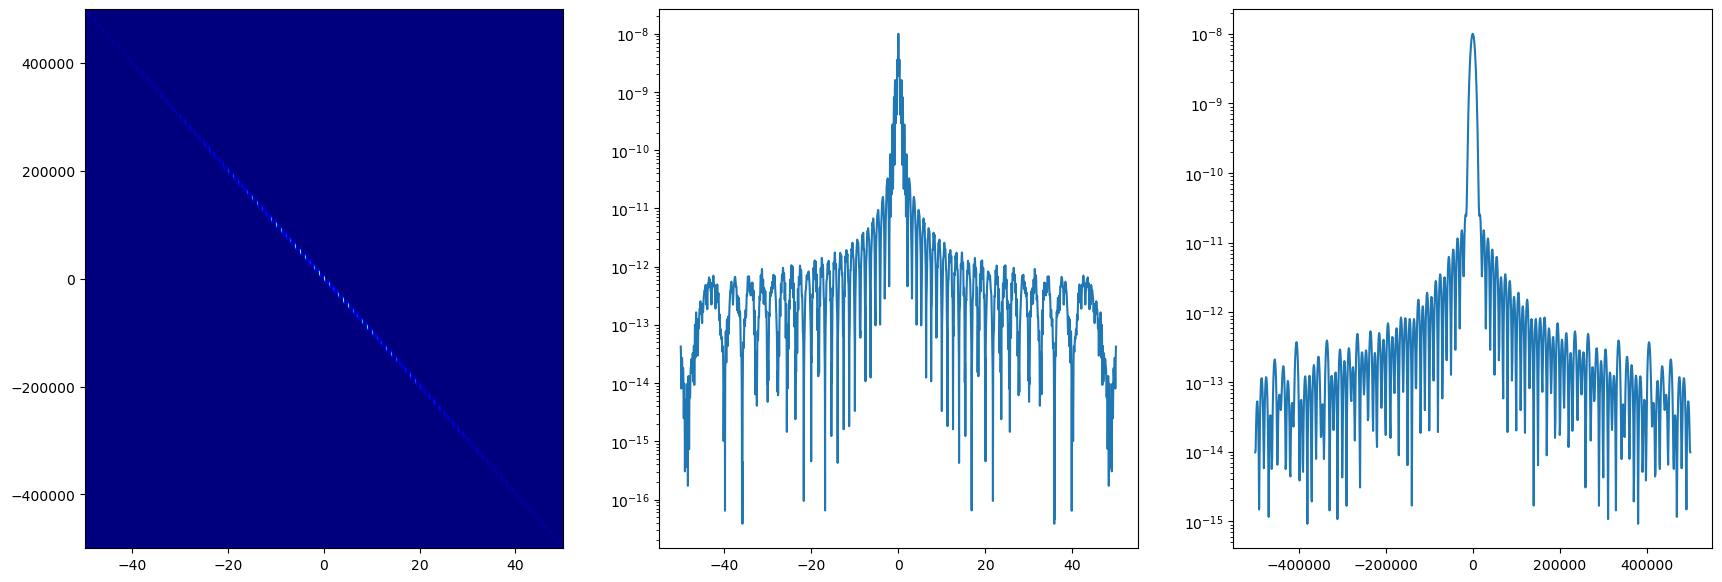

1001it [00:06, 149.30it/s]


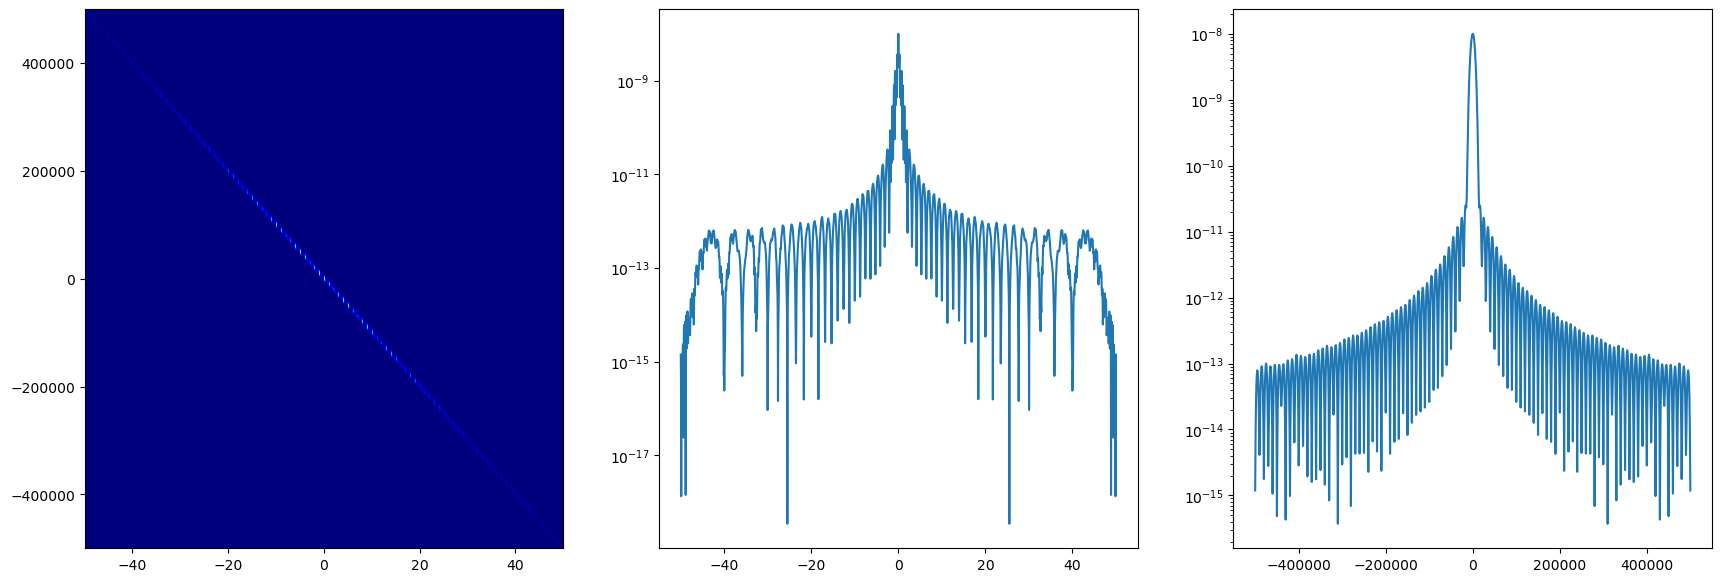

1001it [00:06, 148.25it/s]


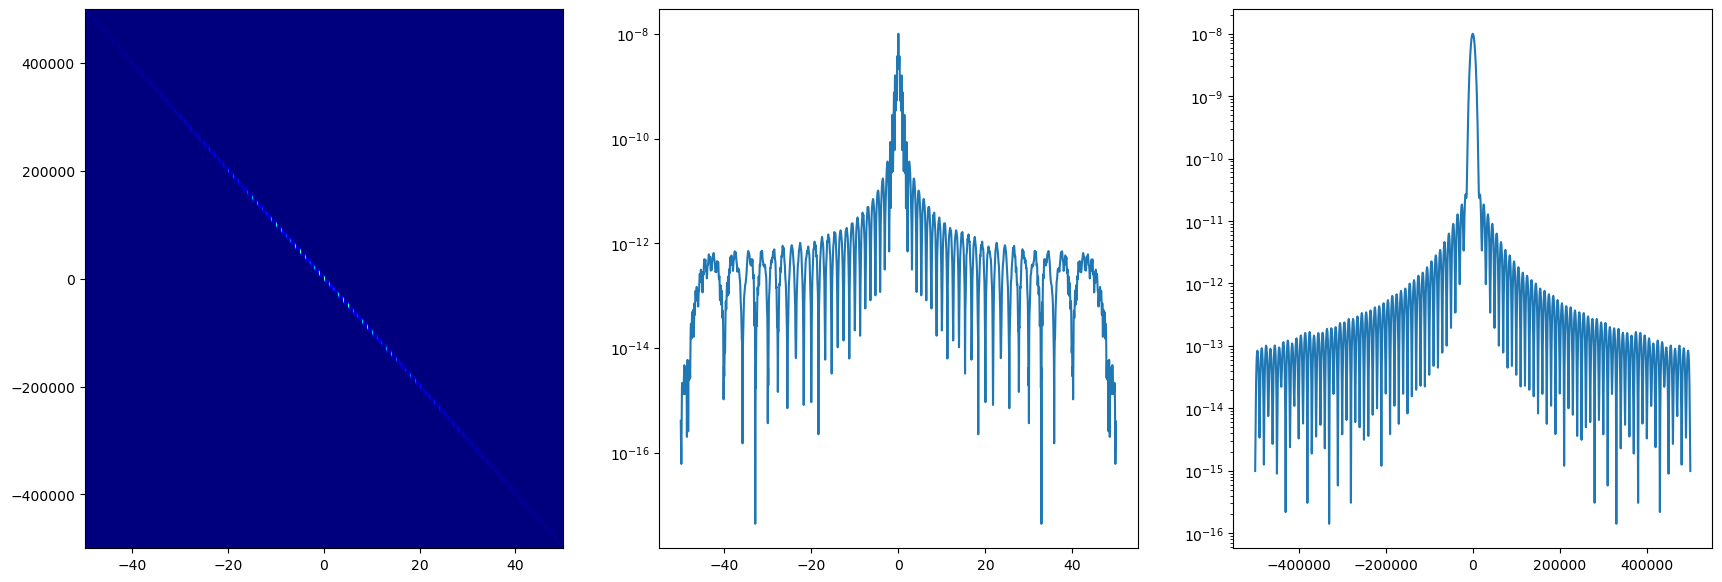

1001it [00:06, 154.24it/s]


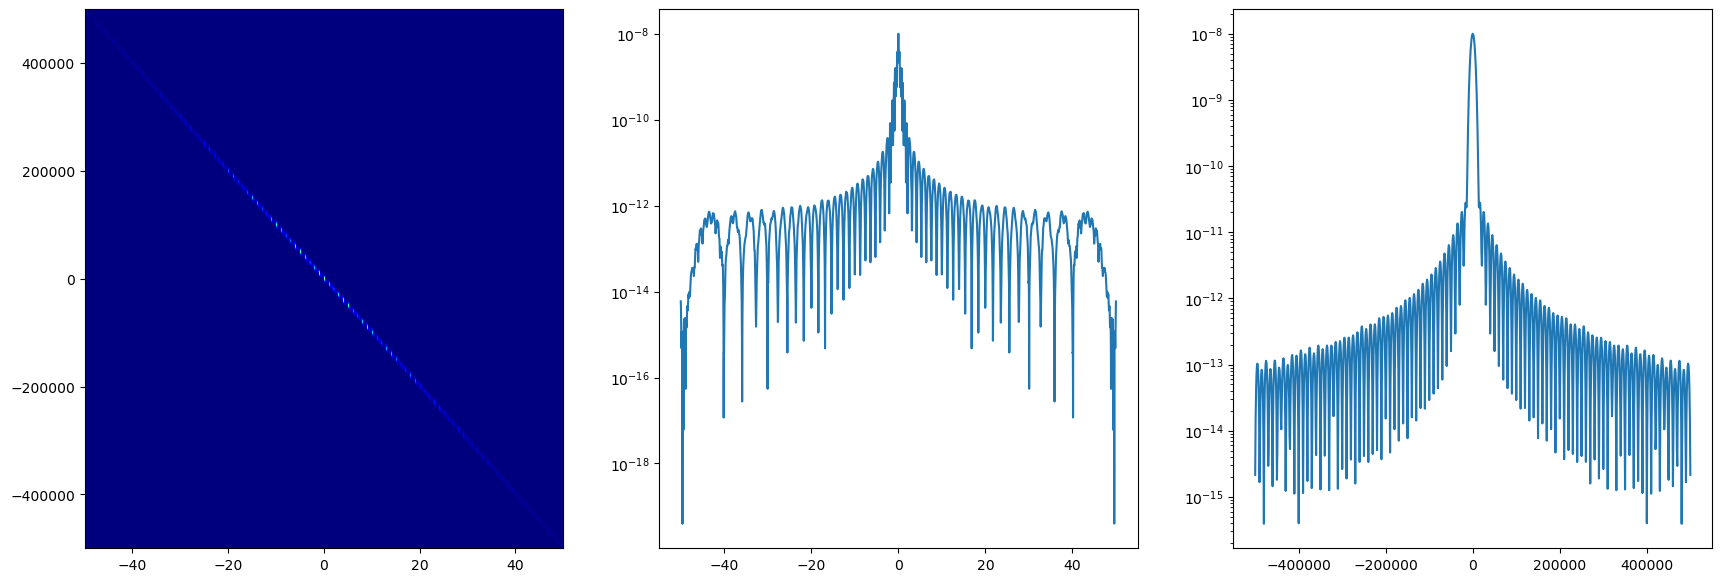

1001it [00:06, 149.13it/s]


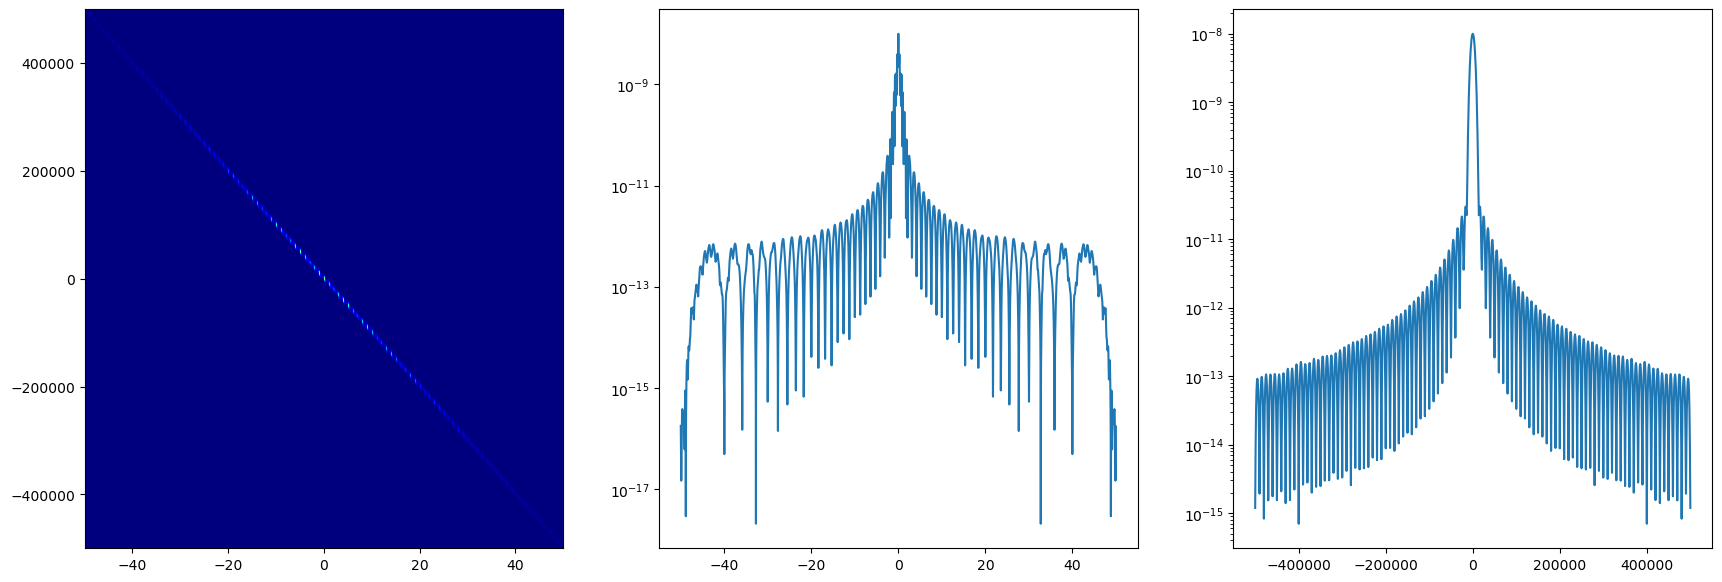

1001it [00:06, 154.55it/s]


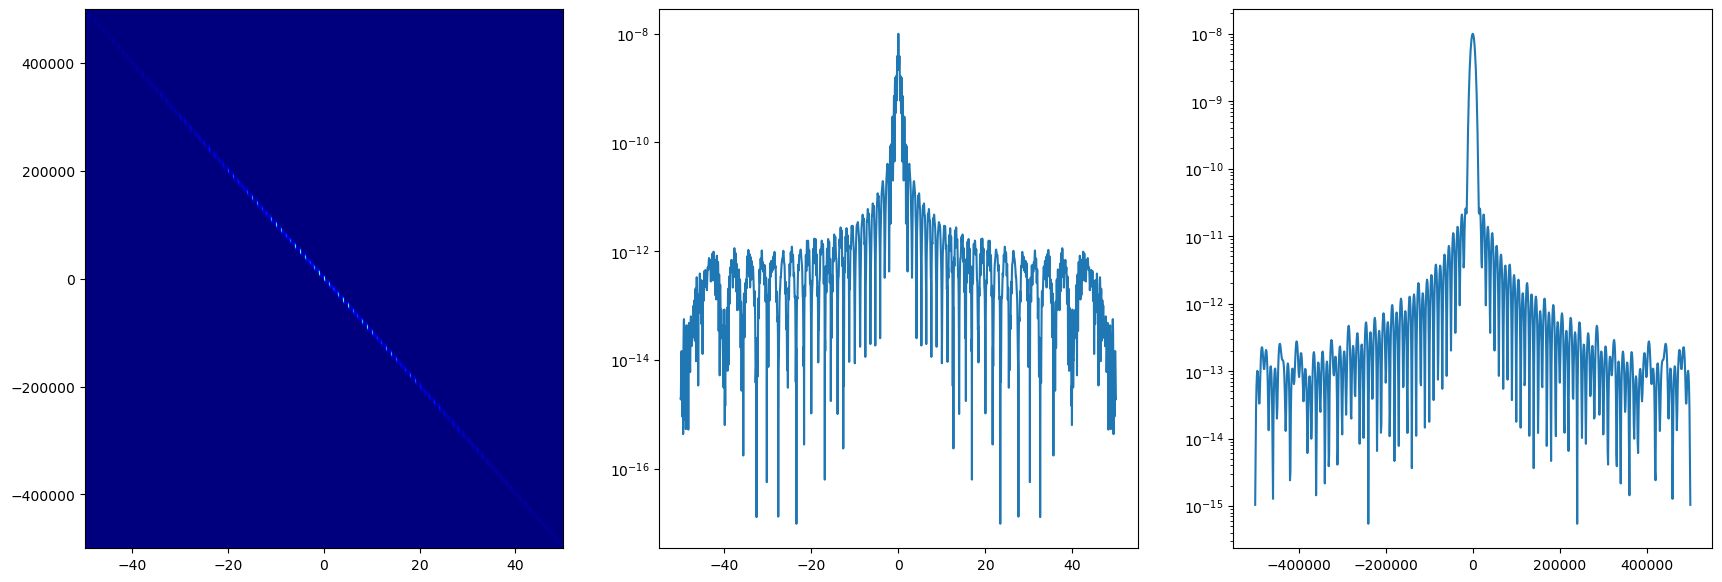

1001it [00:06, 154.52it/s]


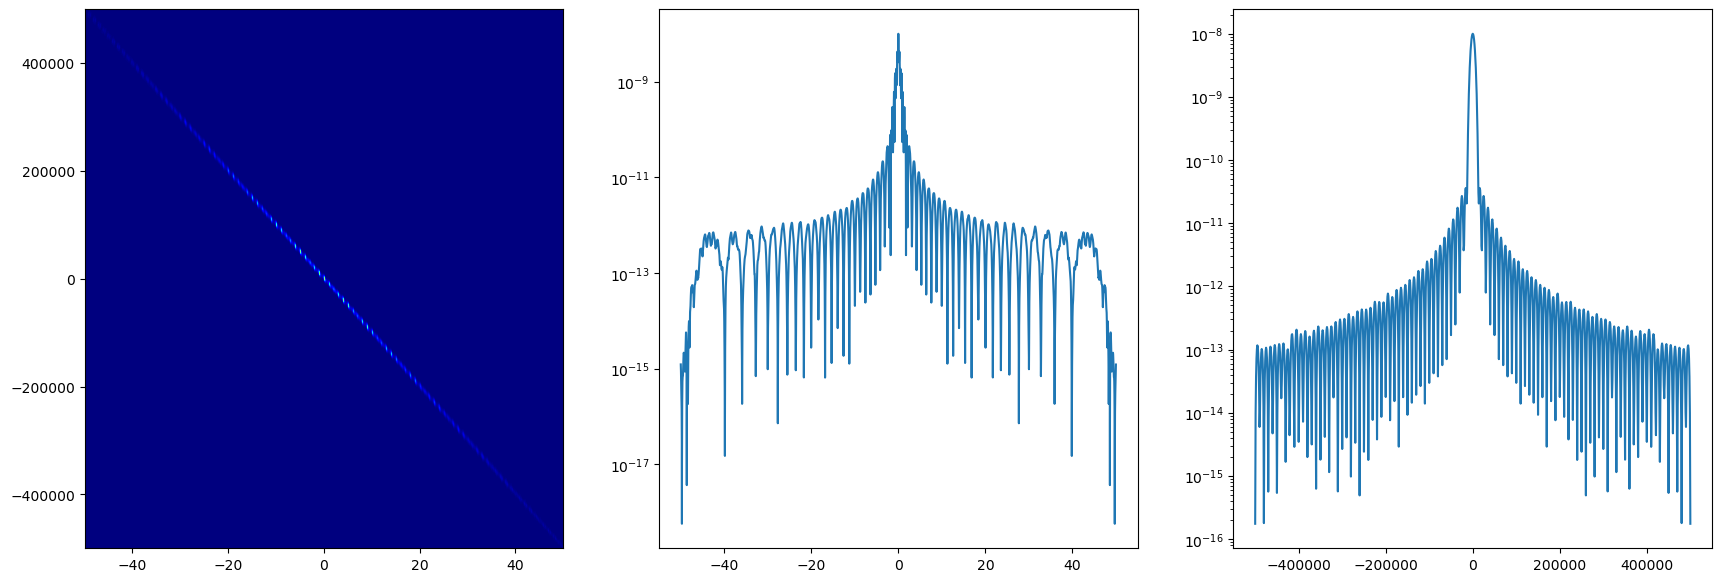

1001it [00:06, 154.67it/s]


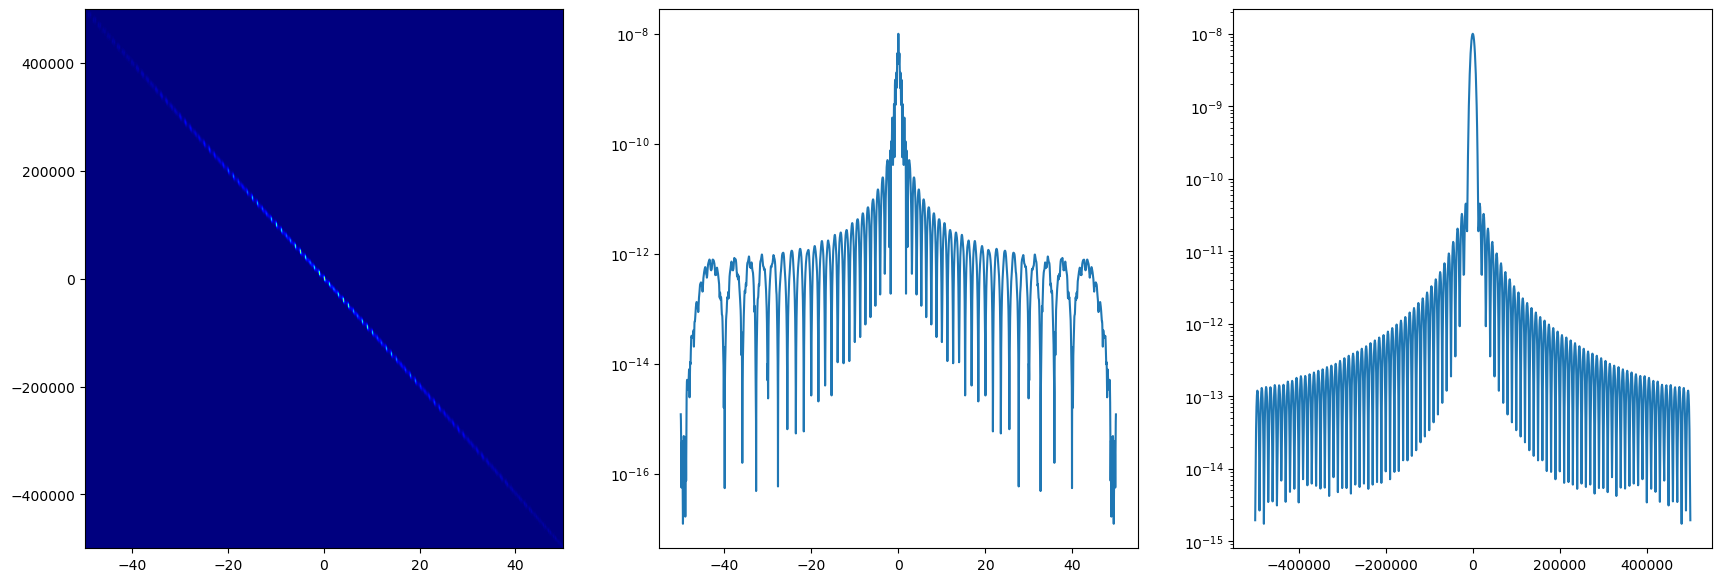

1001it [00:06, 146.92it/s]


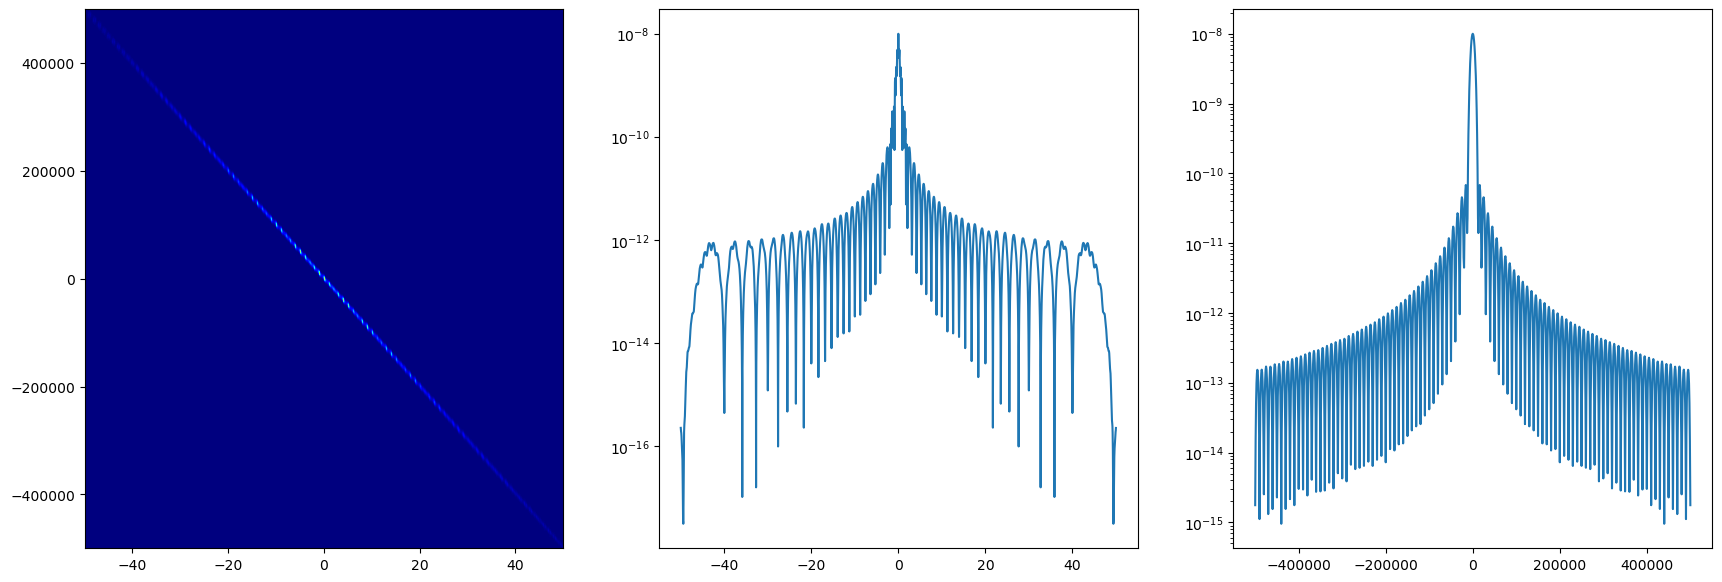

1001it [00:07, 125.48it/s]


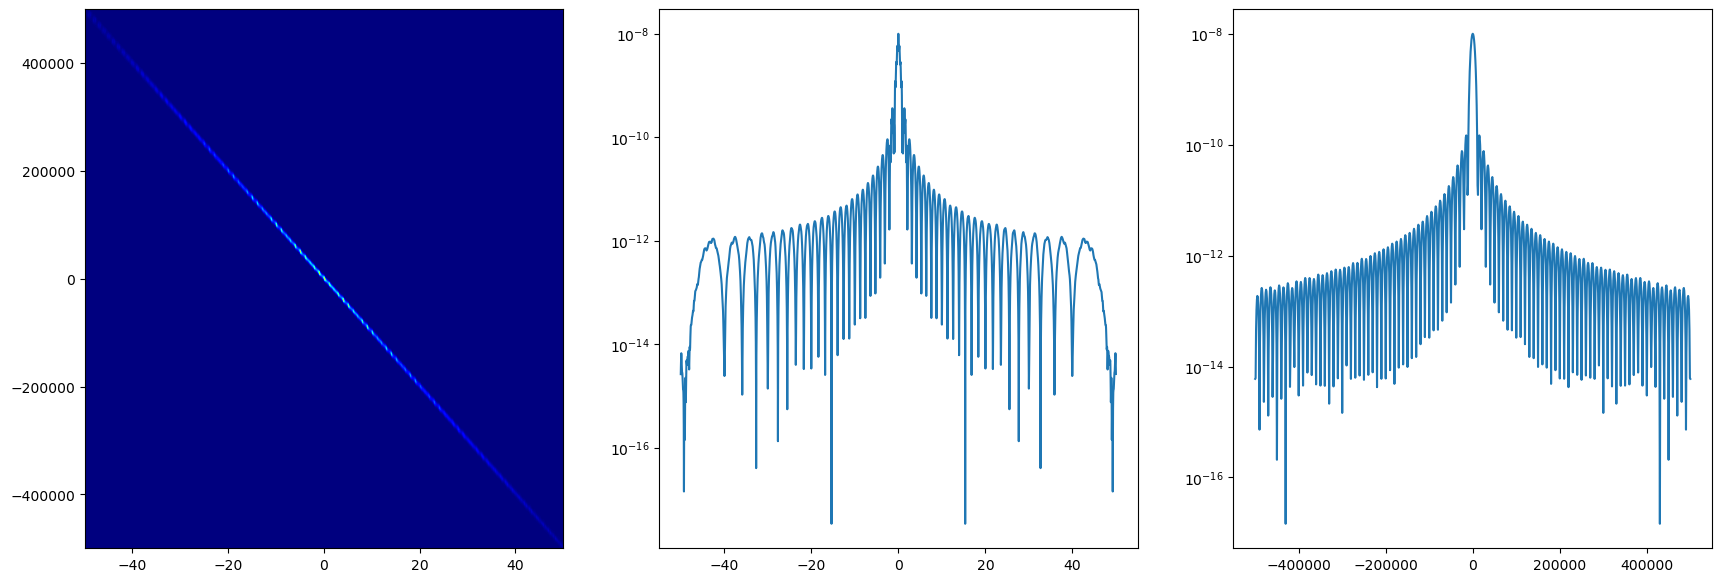

19it [00:00, 54.44it/s] 


KeyboardInterrupt: 

In [ ]:
from src.pulses import RadarPulseGenerator, CommPulseGenerator
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
# Load the saved results
data = np.load('results_data.npz', allow_pickle=True)

# Extract the synthesized signals (complex values)
SynthesizedSignals = data['SynthesizedSignals']  # shape: (num_theta, N)
truesignals = data['truesignal']  # shape: (N,)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

#===============================For Estimation===================================================
distance = 50
my_tau = 2*distance / 3e8
N0 = 10
A = 0.8

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B)
radar_pulse_power = torch.sum(torch.abs(radar_pulse)**2)*dt
synt_pulse_power = torch.sum(torch.abs(synt_pulse)**2)*dt
# ambg_radar = myRadar.cross_correlation(synt_pulse, myRadar.make_delay(synt_pulse, td)*torch.exp(-1j*2*np.pi*fd*t) + np.sqrt(N0)*(torch.randn(len(synt_pulse), device=device) + 1j * torch.randn(len(synt_pulse), device=device)))

fd = np.linspace(-0.5e6, 0.5e6, 1001)  # Frequency shift for Doppler effect
ambg_radar_lfm = torch.zeros((len(fd), len(t)), dtype=torch.complex64)
for fd_idx, _fd in tqdm(enumerate(fd)):
    ambg_radar_lfm[fd_idx, :] = torch.abs(myRadar.cross_correlation(radar_pulse*torch.exp(1j*2*np.pi*_fd*t), radar_pulse).cpu())**2

for idx in range(SynthesizedSignals.shape[0]):
    synt_pulse = torch.tensor(SynthesizedSignals[idx, :], device=device)
    ambg_radar = torch.zeros((len(fd), len(t)), dtype=torch.complex64)
    for fd_idx, _fd in tqdm(enumerate(fd)):
        ambg_radar[fd_idx, :] = torch.abs(myRadar.cross_correlation(synt_pulse*torch.exp(1j*2*np.pi*_fd*t), synt_pulse).cpu())**2

    # Create the figure and axes
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(21,7))

    # Display the image data
    im = ax[0].imshow(torch.abs(ambg_radar).cpu()**2, aspect='auto', extent=[-50, 50, -0.5e6, 0.5e6], cmap='jet')
    ax[1].semilogy(t.cpu()*1e6 - 50, ambg_radar[500, :])
    ax[2].semilogy(fd, ambg_radar[:, len(t)//2].numpy())
    ax[1].semilogy(t.cpu()*1e6 - 50, ambg_radar_lfm[500, :])
    ax[2].semilogy(fd, ambg_radar_lfm[:, len(t)//2].numpy())
    # Show the plot
    plt.show()



# Create the figure and axes
fig, ax = plt.subplots(figsize=(10,10))

# Display the image data
im = ax.imshow(torch.abs(ambg_radar).cpu()**2, aspect='auto', extent=[-50, 50, -0.5e6, 0.5e6], cmap='jet')

# Show the plot
plt.show()

# dis, ta = myRadar.montecarlo_estimation_with_abs(radar_pulse, N0, 2040, np.sqrt(A), 3e8, 1000)
# print("ORIGINAL LFM:::::::::::::============>>>>>>>>>>>>>>>>>")
# print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
# print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)}\n')

# dis, ta = myRadar.montecarlo_estimation_with_abs(torch.tensor(SynthesizedSignals[-1, :], device=device), N0, 2040, np.sqrt(A), 3e8, 1000)
# print("Synt LFM:::::::::::::============>>>>>>>>>>>>>>>>>")
# print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
# print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)}')

In [26]:
fd = np.linspace(-0.5e6, 0.5e6, 1001)  # Frequency shift for Doppler effect
fd[500]
t[len(t)//2]

tensor(5.0001e-05, device='cuda:0')